In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa, torch, torchaudio, joblib
import numpy as np
import scipy.io as sio
from eval_utils import data_spread
from utils import *
import os, pickle, pdb
from concurrent.futures import ThreadPoolExecutor
from params import get_arg
from eval_utils import *
import models

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
config = get_arg(['--nfft','128', '--len', '256', '--b', '256'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
stft = wavToSTFT(config, device)
istft = STFTToWav(config, device)

In [3]:
data_path = '.'
transfer_f = np.array(pickle.load(open(os.path.join(data_path,'transfer_f.pickle'),'rb')))
transfer_f = torch.from_numpy(transfer_f).to(device)
transfer_f.requires_grad = False
if config.feature in ['wav', 'mel', 'stft']:
    accel_raw_data = joblib.load(open(os.path.join(data_path,'stationary_accel_train.joblib'),'rb'))
    sound_raw_data = joblib.load(open(os.path.join(data_path,'stationary_sound_train.joblib'),'rb'))
    accel_raw_data = torch.from_numpy(np.concatenate(accel_raw_data)).to(device)
    sound_raw_data = torch.from_numpy(np.concatenate(sound_raw_data)).to(device)

In [4]:
tra = transfer_f.permute([1,2,0])
with ThreadPoolExecutor() as pool:
    sttransfer_f = torch.stack(list(pool.map(stft, tra)))

/root/anaconda3/envs/1.7/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


In [24]:
taccel = accel_raw_data[:20000]
tsound = sound_raw_data[:20000]

In [41]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, config):
        self.x = x
        self.y = y
        self.config = config
        assert len(self.y) == len(self.x)
        
        self.len = len(self.x) - config.b - config.len - config.latency
        if self.config.future:
            self.len -= self.config.len
        self.perm = torch.arange(int(self.len / self.config.len)) * self.config.len
        
    def __len__(self):
        return len(self.perm)
    
    def __getitem__(self, idx):
        idx = self.perm[idx]
        index = idx + self.config.latency
        frame_size = self.config.b
        if self.config.future:
            frame_size += self.config.len
        x = self.x[idx:idx + self.config.b + self.config.len].transpose(0,1)
        y = self.y[index + frame_size:index + frame_size + self.config.len]
        return x, y
        
dataset = Dataset(taccel, tsound, config)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [42]:
model = getattr(models, config.model)((config.len + config.b,), (8,), 12, config.len, config).to(device)

In [47]:
y_p = []
y = []
model.eval()
with torch.no_grad():
    for data, label in dataloader:
        _y = model(data.to(device))
        y.append(_y)
        y_p.append(conv_with_S(_y, transfer_f,config, device))

y = torch.cat(y,1).squeeze(0)
y_p = torch.cat(y_p,1).squeeze(0)

In [53]:
with ThreadPoolExecutor() as pool:
    y_s = torch.stack(list(pool.map(stft,y.transpose(-1,-2))))

In [55]:
sttransfer_f.shape

torch.Size([8, 8, 65, 3])

In [56]:
def padding(signal, Ls):
    _pad = torch.zeros((signal.size(0), Ls - 1, signal.size(2)), device=signal.device, dtype=signal.dtype)
    return torch.cat([_pad, signal],1)

def st_conv_with_S(config, device):
    # S_data = (Ls, K, M) ,signal(batch, frames, K)
    def _st_conv_with_S(inputs):
        S_data, signal = inputs
        Ls = S_data.size(0)
        K = S_data.size(1)
        signal = padding(signal, Ls)
        real = F.conv1d(signal.real.transpose(1,2), S_data.real.permute([2,1,0]).type(signal.real.dtype))
        out = torch.zeros(real.shape, dtype=signal.dtype, device=signal.device)
        imag = F.conv1d(signal.imag.transpose(1,2), S_data.imag.permute([2,1,0]).type(signal.imag.dtype))
        out.real = real
        out.imag = imag
        return out
    return _st_conv_with_S



def conv(transfer, config, device):
    # transfer = (K, M, n_bins, frames)
    transfer = transfer.permute([2,3,0,1]) # (n_bins, frames, K, M)
    conv_filt = st_conv_with_S(config, device)
    def _conv(signals):
        # signal (batch, channel, n_bins, frames)
        signals = signals.permute([2,0,3,1]) # (n_bins, batch, frames, channel)
        # S_data (frames, K, M), signal(batch, frames, channel)
#         with ThreadPoolExecutor(1) as pool:
#             s_signal = torch.stack(list(pool.map(conv_filt,zip(transfer, signals))))
        s_signal = torch.stack(list(map(conv_filt,zip(transfer, signals))))
        return s_signal
    return _conv
filt = conv(sttransfer_f, config, device)

In [64]:
y_s_p = filt(y_s.unsqueeze(0)).permute([1,2,0,3])

In [68]:
with ThreadPoolExecutor() as pool:
    y_pp = torch.stack(list(pool.map(istft,y_s_p))).transpose(1,2).squeeze(0)

In [69]:
y_p.shape

torch.Size([19200, 8])

In [70]:
torch.mean(y_pp - y_p)

tensor(0.0003, device='cuda:0', dtype=torch.float64)

In [71]:
y_p.shape

torch.Size([19200, 8])

<Figure size 432x288 with 0 Axes>

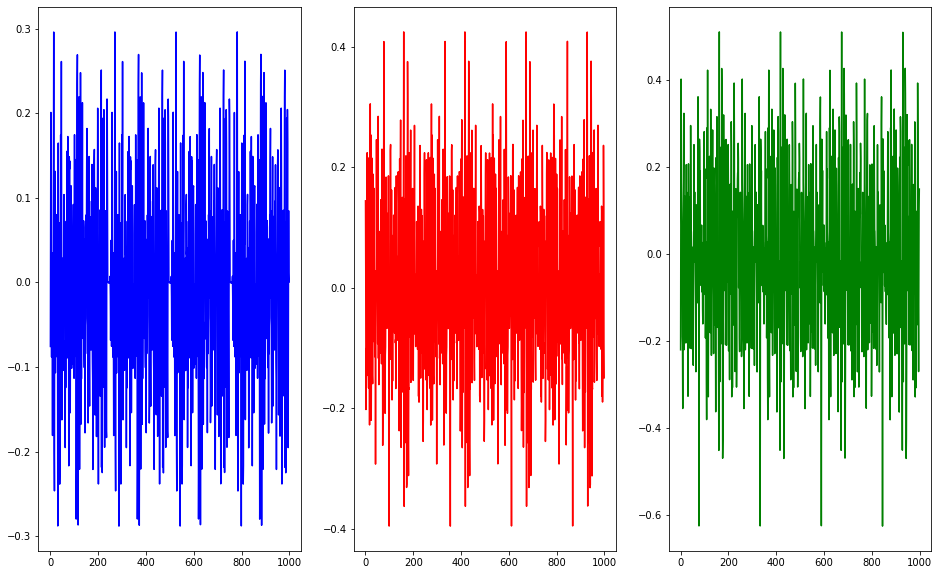

In [76]:
fig = plt.figure()
fig, ax_lst = plt.subplots(1, 3, figsize=(16,10))
ax_lst[0].plot(y_p[10000:11000,0].cpu().numpy(), color="blue")
ax_lst[1].plot(y_pp[10000:11000,0].cpu().numpy(), color="red")
ax_lst[2].plot(y_p[10000:11000,0].cpu().numpy() - y_pp[10000:11000,0].cpu().numpy(), color="green")
# plt.specgram(y_p[:,:,0].cpu().numpy(), NFFT=128)
plt.show()